# Goal of this Notebook is to find a way to apply higher dimensions to the predator prey problem similar to how Champion et al. achieved with their Lorenz equations

# Imports

In [3]:
import numpy as np
from scipy.integrate import odeint
from scipy.special import legendre, chebyt
import sys

sys.path.append('../Inspiration/Champion et al./src')
from sindy_utils import library_size

## Part 1 - Analysing Champion et al.

In [7]:
def get_lorenz_data(n_ics, noise_strength=0):
    """
    Generate a set of Lorenz training data for multiple random initial conditions.

    Arguments:
        n_ics - Integer specifying the number of initial conditions to use.
        noise_strength - Amount of noise to add to the data.

    Return:
        data - Dictionary containing elements of the dataset. See generate_lorenz_data()
        doc string for list of contents.
    """
    t = np.arange(0, 5, .02)
    n_steps = t.size
    input_dim = 128
    
    ic_means = np.array([0,0,25])
    ic_widths = 2*np.array([36,48,41])

    # training data
    ics = ic_widths*(np.random.rand(n_ics, 3)-.5) + ic_means
    data = generate_lorenz_data(ics, t, input_dim, linear=False, normalization=np.array([1/40,1/40,1/40]))
    data['x'] = data['x'].reshape((-1,input_dim)) + noise_strength*np.random.randn(n_steps*n_ics,input_dim)
    data['dx'] = data['dx'].reshape((-1,input_dim)) + noise_strength*np.random.randn(n_steps*n_ics,input_dim)
    data['ddx'] = data['ddx'].reshape((-1,input_dim)) + noise_strength*np.random.randn(n_steps*n_ics,input_dim)

    return data


def lorenz_coefficients(normalization, poly_order=3, sigma=10., beta=8/3, rho=28.):
    """
    Generate the SINDy coefficient matrix for the Lorenz system.

    Arguments:
        normalization - 3-element list of array specifying scaling of each Lorenz variable
        poly_order - Polynomial order of the SINDy model.
        sigma, beta, rho - Parameters of the Lorenz system
    """
    Xi = np.zeros((library_size(3,poly_order),3))
    Xi[1,0] = -sigma
    Xi[2,0] = sigma*normalization[0]/normalization[1]
    Xi[1,1] = rho*normalization[1]/normalization[0]
    Xi[2,1] = -1
    Xi[6,1] = -normalization[1]/(normalization[0]*normalization[2])
    Xi[3,2] = -beta
    Xi[5,2] = normalization[2]/(normalization[0]*normalization[1])
    return Xi


def simulate_lorenz(z0, t, sigma=10., beta=8/3, rho=28.):
    """
    Simulate the Lorenz dynamics.

    Arguments:
        z0 - Initial condition in the form of a 3-value list or array.
        t - Array of time points at which to simulate.
        sigma, beta, rho - Lorenz parameters

    Returns:
        z, dz, ddz - Arrays of the trajectory values and their 1st and 2nd derivatives.
    """
    f = lambda z,t : [sigma*(z[1] - z[0]), z[0]*(rho - z[2]) - z[1], z[0]*z[1] - beta*z[2]]
    df = lambda z,dz,t : [sigma*(dz[1] - dz[0]),
                          dz[0]*(rho - z[2]) + z[0]*(-dz[2]) - dz[1],
                          dz[0]*z[1] + z[0]*dz[1] - beta*dz[2]]

    z = odeint(f, z0, t)

    dt = t[1] - t[0]
    dz = np.zeros(z.shape)
    ddz = np.zeros(z.shape)
    for i in range(t.size):
        dz[i] = f(z[i],dt*i)
        ddz[i] = df(z[i], dz[i], dt*i)
    return z, dz, ddz


def generate_lorenz_data(ics, t, n_points, linear=True, normalization=None,
                            sigma=10, beta=8/3, rho=28):
    """
    Generate high-dimensional Lorenz data set.

    Arguments:
        ics - Nx3 array of N initial conditions
        t - array of time points over which to simulate
        n_points - size of the high-dimensional dataset created
        linear - Boolean value. If True, high-dimensional dataset is a linear combination
        of the Lorenz dynamics. If False, the dataset also includes cubic modes.
        normalization - Optional 3-value array for rescaling the 3 Lorenz variables.
        sigma, beta, rho - Parameters of the Lorenz dynamics.

    Returns:
        data - Dictionary containing elements of the dataset. This includes the time points (t),
        spatial mapping (y_spatial), high-dimensional modes used to generate the full dataset
        (modes), low-dimensional Lorenz dynamics (z, along with 1st and 2nd derivatives dz and
        ddz), high-dimensional dataset (x, along with 1st and 2nd derivatives dx and ddx), and
        the true Lorenz coefficient matrix for SINDy.
    """

    n_ics = ics.shape[0]
    n_steps = t.size
    dt = t[1]-t[0]

    d = 3
    z = np.zeros((n_ics,n_steps,d))
    dz = np.zeros(z.shape)
    ddz = np.zeros(z.shape)
    for i in range(n_ics):
        z[i], dz[i], ddz[i] = simulate_lorenz(ics[i], t, sigma=sigma, beta=beta, rho=rho)


    if normalization is not None:
        z *= normalization
        dz *= normalization
        ddz *= normalization

    n = n_points
    L = 1
    y_spatial = np.linspace(-L,L,n)

    modes = np.zeros((2*d, n))
    for i in range(2*d):
        modes[i] = legendre(i)(y_spatial)
        # modes[i] = chebyt(i)(y_spatial)
        # modes[i] = np.cos((i+1)*np.pi*y_spatial/2)
    x1 = np.zeros((n_ics,n_steps,n))
    x2 = np.zeros((n_ics,n_steps,n))
    x3 = np.zeros((n_ics,n_steps,n))
    x4 = np.zeros((n_ics,n_steps,n))
    x5 = np.zeros((n_ics,n_steps,n))
    x6 = np.zeros((n_ics,n_steps,n))

    x = np.zeros((n_ics,n_steps,n))
    dx = np.zeros(x.shape)
    ddx = np.zeros(x.shape)
    for i in range(n_ics):
        for j in range(n_steps):
            x1[i,j] = modes[0]*z[i,j,0]
            x2[i,j] = modes[1]*z[i,j,1]
            x3[i,j] = modes[2]*z[i,j,2]
            x4[i,j] = modes[3]*z[i,j,0]**3
            x5[i,j] = modes[4]*z[i,j,1]**3
            x6[i,j] = modes[5]*z[i,j,2]**3

            x[i,j] = x1[i,j] + x2[i,j] + x3[i,j]
            if not linear:
                x[i,j] += x4[i,j] + x5[i,j] + x6[i,j]

            dx[i,j] = modes[0]*dz[i,j,0] + modes[1]*dz[i,j,1] + modes[2]*dz[i,j,2]
            if not linear:
                dx[i,j] += modes[3]*3*(z[i,j,0]**2)*dz[i,j,0] + modes[4]*3*(z[i,j,1]**2)*dz[i,j,1] + modes[5]*3*(z[i,j,2]**2)*dz[i,j,2]
            
            ddx[i,j] = modes[0]*ddz[i,j,0] + modes[1]*ddz[i,j,1] + modes[2]*ddz[i,j,2]
            if not linear:
                ddx[i,j] += modes[3]*(6*z[i,j,0]*dz[i,j,0]**2 + 3*(z[i,j,0]**2)*ddz[i,j,0]) \
                          + modes[4]*(6*z[i,j,1]*dz[i,j,1]**2 + 3*(z[i,j,1]**2)*ddz[i,j,1]) \
                          + modes[5]*(6*z[i,j,2]*dz[i,j,2]**2 + 3*(z[i,j,2]**2)*ddz[i,j,2])

    if normalization is None:
        sindy_coefficients = lorenz_coefficients([1,1,1], sigma=sigma, beta=beta, rho=rho)
    else:
        sindy_coefficients = lorenz_coefficients(normalization, sigma=sigma, beta=beta, rho=rho)

    data = {}
    data['t'] = t
    data['y_spatial'] = y_spatial
    data['modes'] = modes
    data['x'] = x
    data['dx'] = dx
    data['ddx'] = ddx
    data['z'] = z
    data['dz'] = dz
    data['ddz'] = ddz
    data['sindy_coefficients'] = sindy_coefficients.astype(np.float32)

    return data


## Part 2 - Simple Predator Prey problem

In [11]:
# Function that generates the predator-prey data for the following params alpha, beta, delta, gamma
from scipy.integrate import odeint

def generate_pred_prey(z0, t, alpha=0.1, beta=0.1, delta=0.1, gamma=0.1):
    """
    Simulate the predator-prey dynamics.

    Arguments:
        z0 - Initial condition in the form of a 2-value list or array.
        t - Array of time points at which to simulate.
        alpha, beta, delta, gamma - Predator-prey parameters

    Returns:
        z, dz, ddz - Arrays of the trajectory values and their 1st and 2nd derivatives.
    """

    def lotka_volterra(z, t):
        x, y = z
        dxdt = alpha * x - beta * x * y
        dydt = delta * x * y - gamma * y
        return [dxdt, dydt]

    # Simulate the system
    z = odeint(lotka_volterra, z0, t)

    # Compute dz/dt using the system equations directly
    dz = np.array([lotka_volterra(zi, ti) for zi, ti in zip(z, t)])

    # Compute d²z/dt² numerically from dz
    ddz = np.gradient(dz, t, axis=0)

    return z, dz, ddz

### Proof of concept

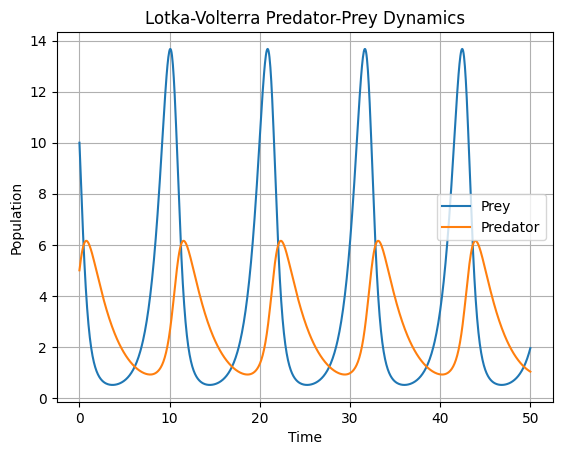

In [12]:
import matplotlib.pyplot as plt

# Time points
t = np.linspace(0, 50, 1000)

# Initial populations: [prey, predator]
z0 = [10, 5]

# Run simulation
z, dz, ddz = generate_pred_prey(z0, t, alpha=1.1, beta=0.4, delta=0.1, gamma=0.4)

# Plot prey and predator populations
plt.plot(t, z[:, 0], label='Prey')
plt.plot(t, z[:, 1], label='Predator')
plt.legend()
plt.title('Lotka-Volterra Predator-Prey Dynamics')
plt.xlabel('Time')
plt.ylabel('Population')
plt.grid(True)
plt.show()


## Part 3 - Increasing dimenstionality

In [18]:
def lotka_volterra_coefficients(normalization = [1,1,1,1], poly_order=3, alpha=1.1, beta=0.4, delta=0.1, gamma=0.4):
    """
    Generate the SINDy coefficient matrix for the Lotka-Volterra system.

    Arguments:
        normalization - 4-element list of array specifying scaling of each Lotka-Volterra variable
        poly_order - Polynomial order of the SINDy model.
        alpha, beta, delta, gamma - Parameters of the Lotka-Volterra system
    """
    Xi = np.zeros((library_size(2,poly_order),2))
    Xi[1,0] = alpha
    Xi[2,0] = -beta*normalization[0]/normalization[1]
    Xi[1,1] = delta*normalization[1]/normalization[0]
    Xi[2,1] = -gamma
    return Xi



# Similar to the lorenz system we look to generate a higher-dimensional dataset of the Lotka-Volterra system creating a function called
# generate_pred_prey_data

def generate_pred_prey_data(ics, t, n_points, linear=True, normalization=None,
                            alpha=1.1, beta=0.4, delta=0.1, gamma=0.4):
    """
    Generate high-dimensional Lotka-Volterra data set.
    Arguments:
        ics - Nx2 array of N initial conditions
        t - array of time points over which to simulate
        n_points - size of the high-dimensional dataset created
        linear - Boolean value. If True, high-dimensional dataset is a linear combination
        of the Lotka-Volterra dynamics. If False, the dataset also includes cubic modes.
        normalization - Optional 2-value array for rescaling the 2 Lotka-Volterra variables.
        alpha, beta, delta, gamma - Parameters of the Lotka-Volterra dynamics.
    Returns:
        data - Dictionary containing elements of the dataset. This includes the time points (t),
        spatial mapping (y_spatial), high-dimensional modes used to generate the full dataset
        (modes), low-dimensional Lotka-Volterra dynamics (z, along with 1st and 2nd derivatives dz and
        ddz), high-dimensional dataset (x, along with 1st and 2nd derivatives dx and ddx), and
        the true Lotka-Volterra coefficient matrix for SINDy.
    """
    n_ics = ics.shape[0]
    n_steps = t.size
    dt = t[1]-t[0]
    d = 2
    z = np.zeros((n_ics,n_steps,d))
    dz = np.zeros(z.shape)
    ddz = np.zeros(z.shape)
    for i in range(n_ics):
        z[i], dz[i], ddz[i] = generate_pred_prey(ics[i], t, alpha=alpha, beta=beta, delta=delta, gamma=gamma)

    if normalization is not None:
        z *= normalization
        dz *= normalization
        ddz *= normalization
    
    n = n_points
    L = 1
    y_spatial = np.linspace(-L,L,n)
    modes = np.zeros((2*d, n))
    for i in range(2*d):
        modes[i] = legendre(i)(y_spatial)
        # modes[i] = chebyt(i)(y_spatial)
        # modes[i] = np.cos((i+1)*np.pi*y_spatial/2)
    x1 = np.zeros((n_ics,n_steps,n))
    x2 = np.zeros((n_ics,n_steps,n))
    x3 = np.zeros((n_ics,n_steps,n))
    x4 = np.zeros((n_ics,n_steps,n))
    x5 = np.zeros((n_ics,n_steps,n))
    x6 = np.zeros((n_ics,n_steps,n))

    x = np.zeros((n_ics,n_steps,n))
    dx = np.zeros(x.shape)
    ddx = np.zeros(x.shape)
    for i in range(n_ics):
        for j in range(n_steps):
            x1[i,j] = modes[0]*z[i,j,0]
            x2[i,j] = modes[1]*z[i,j,1]
            x3[i,j] = modes[2]*z[i,j,0]**2
            x4[i,j] = modes[3]*z[i,j,1]**2

            x[i,j] = x1[i,j] + x2[i,j] + x3[i,j] + x4[i,j]
            if not linear:
                x[i,j] += x6[i,j]

            dx[i,j] = modes[0]*dz[i,j,0] + modes[1]*dz[i,j,1]
            if not linear:
                dx[i,j] += modes[2]*(2*z[i,j,0]*dz[i,j,0]) + modes[3]*(2*z[i,j,1]*dz[i,j,1])

            ddx[i,j] = modes[0]*ddz[i,j,0] + modes[1]*ddz[i,j,1]
            if not linear:
                ddx[i,j] += modes[2]*(2*dz[i,j,0]**2 + 2*z[i,j,0]*ddz[i,j,0]) \
                          + modes[3]*(2*dz[i,j,1]**2 + 2*z[i,j,1]*ddz[i,j,1])
    if normalization is None:
        sindy_coefficients = lotka_volterra_coefficients([1,1,1,1], alpha=alpha, beta=beta, delta=delta, gamma=gamma)
    else:
        sindy_coefficients = lotka_volterra_coefficients(normalization, alpha=alpha, beta=beta, delta=delta, gamma=gamma)
    data = {}
    data['t'] = t
    data['y_spatial'] = y_spatial
    data['modes'] = modes
    data['x'] = x
    data['dx'] = dx
    data['ddx'] = ddx
    data['z'] = z
    data['dz'] = dz
    data['ddz'] = ddz
    data['sindy_coefficients'] = sindy_coefficients.astype(np.float32)
    return data

def get_pred_prey_data(n_ics, noise_strength=0):
    """
    Generate a set of Lotka-Volterra training data for multiple random initial conditions.

    Arguments:
        n_ics - Integer specifying the number of initial conditions to use.
        noise_strength - Amount of noise to add to the data.

    Return:
        data - Dictionary containing elements of the dataset. See generate_pred_prey_data()
        doc string for list of contents.
    """
    t = np.arange(0, 50, .02)
    n_steps = t.size
    input_dim = 128
    
    ic_means = np.array([10,5])
    ic_widths = 2*np.array([10,5])

    # training data
    ics = ic_widths*(np.random.rand(n_ics, 2)-.5) + ic_means
    data = generate_pred_prey_data(ics, t, input_dim, linear=False, normalization=np.array([1/40,1/40]))
    data['x'] = data['x'].reshape((-1,input_dim)) + noise_strength*np.random.randn(n_steps*n_ics,input_dim)
    data['dx'] = data['dx'].reshape((-1,input_dim)) + noise_strength*np.random.randn(n_steps*n_ics,input_dim)
    data['ddx'] = data['ddx'].reshape((-1,input_dim)) + noise_strength*np.random.randn(n_steps*n_ics,input_dim)

    return data
    

### Proof of concept

Lorenz data generated.
Lotka-Volterra data generated.
(10, 2500, 2)
(2500,)


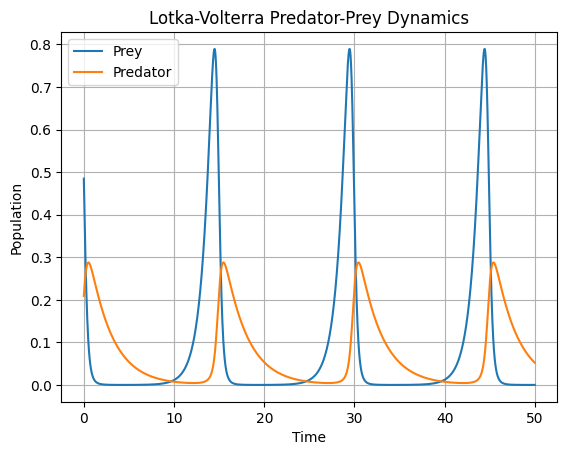

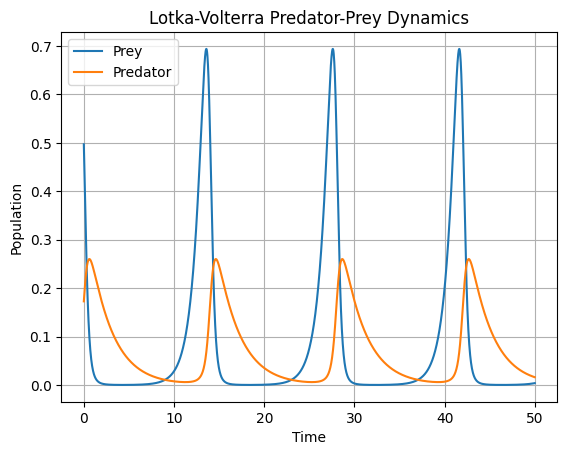

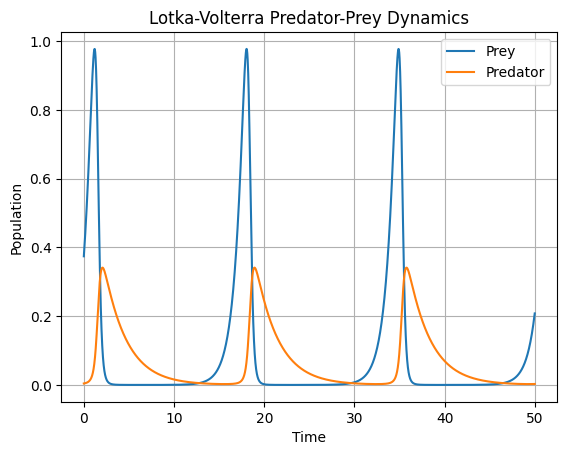

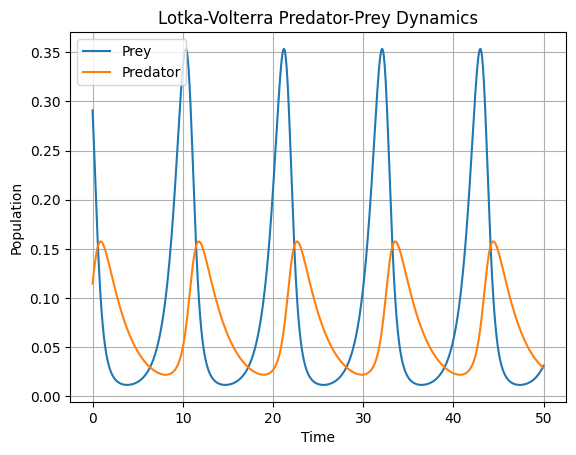

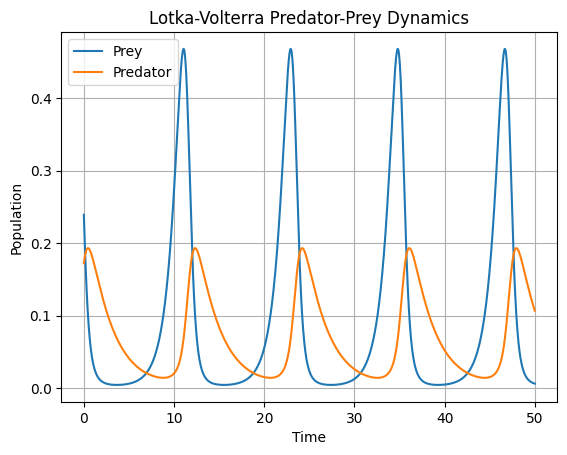

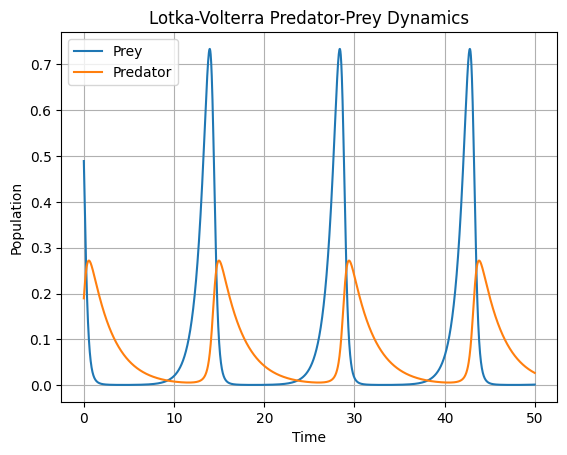

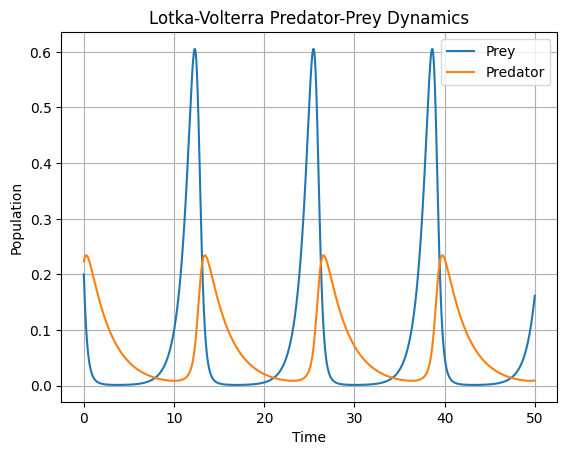

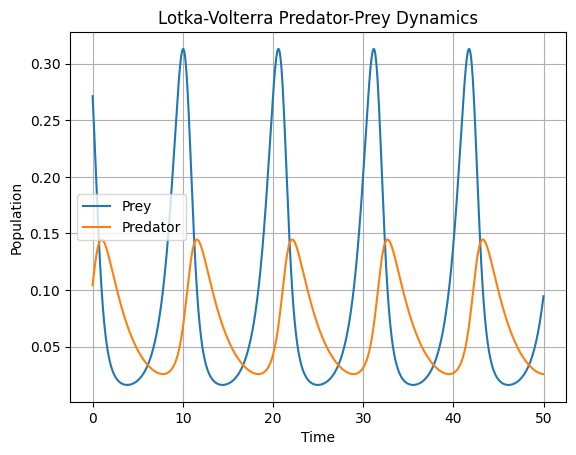

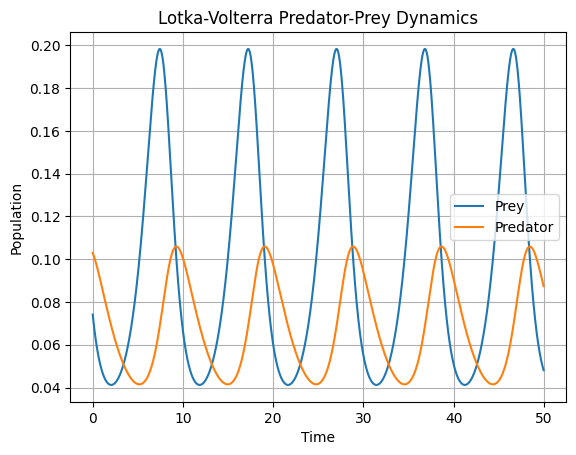

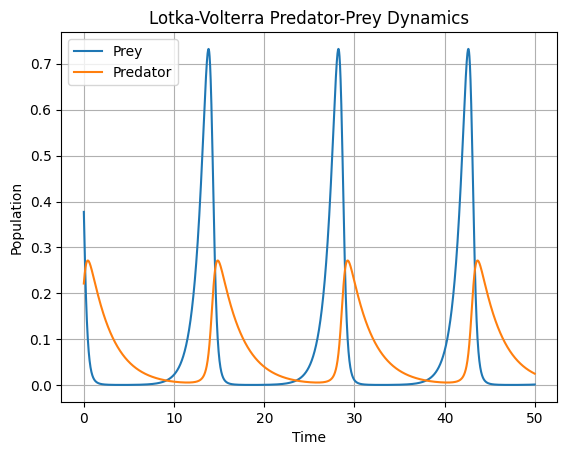

In [23]:
# Example usage
if __name__ == "__main__":
    # Generate Lorenz data
    lorenz_data = get_lorenz_data(10, noise_strength=0.01)
    print("Lorenz data generated.")

    # Generate Lotka-Volterra data
    pred_prey_data = get_pred_prey_data(10, noise_strength=0.01)
    print("Lotka-Volterra data generated.")
    print(np.shape(pred_prey_data['z']))
    print(np.shape(pred_prey_data['t']))
    for i in range(10):
        # Plot lotka-volterra data
        plt.plot(pred_prey_data['t'], pred_prey_data['z'][i][:, 0], label='Prey')
        plt.plot(pred_prey_data['t'], pred_prey_data['z'][i][:, 1], label='Predator')
        plt.legend()
        plt.title('Lotka-Volterra Predator-Prey Dynamics')
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.grid(True)
        plt.show()
